<a href="https://colab.research.google.com/github/AugustoBonifacio001/AugustoBonifacio001/blob/main/evento_Sag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

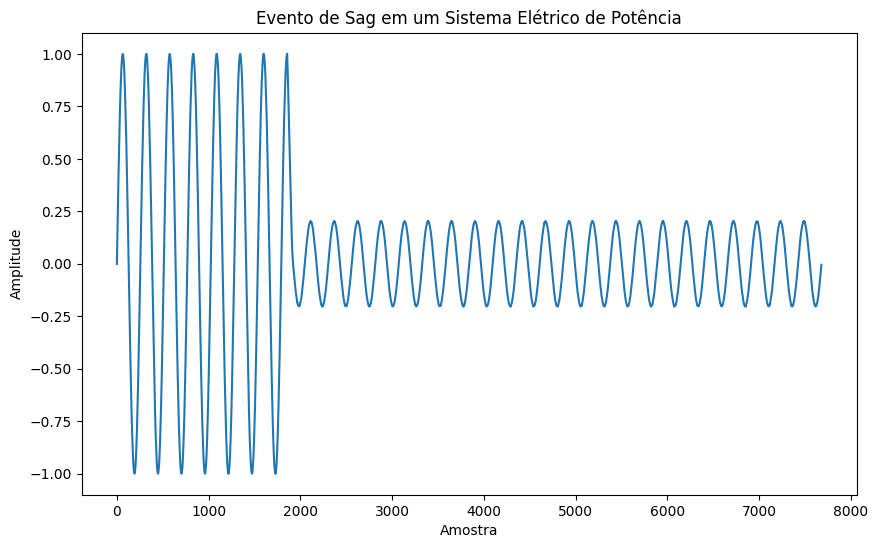

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def evento_sag(SNRdb):
    Vm1 = 1  # Valor máximo do 1º harmônico
    fase = 0
    FreqFund = 60
    Npc = 256  # Número de Pontos por Ciclo
    Nc = 30  # Número de Ciclos
    Npt = Nc * Npc  # Número total de pontos
    Fs = Npc * 60  # Frequência de Amostragem
    T = 1 / Fs  # Período de amostragem
    w0 = 2 * np.pi * FreqFund  # Frequência em Radianos
    t = np.arange(0, T * Npt, T)

    # Parâmetros do evento "sag"
    no = np.random.randint(7 * Npc, 8 * Npc)  # Índice do início do sag
    n = no
    afundamento = np.random.uniform(0.1, 0.9)
    passo = afundamento / (Npc / 4)

    # Geração do ruído
    Ps = (Vm1 ** 2) / 2
    Pr = Ps / (10 ** (SNRdb / 10))
    desvio = np.sqrt(Pr)
    R = np.random.normal(0, desvio, Nc * Npc)
    R -= np.mean(R)

    # Geração do evento "sag"
    x1 = np.zeros(Nc * Npc)
    for n1 in range(Nc * Npc):
        x1[n1] = Vm1 * np.sin(w0 * t[n1] + fase)
        if no < n1 < (no + (Npc / 4) + 1):
            Vm1 -= passo

    xIn = x1 + R

    return xIn, n, Nc, FreqFund

# Configuração
SNRdb = 60

# Geração do sinal com a introdução de ruído e o evento "sag"
xIn, _, _, _ = evento_sag(SNRdb)

# Visualização do sinal gerado
plt.figure(figsize=(10, 6))
plt.plot(xIn)
plt.title('Evento de Sag em um Sistema Elétrico de Potência')
plt.xlabel('Amostra')
plt.ylabel('Amplitude')
plt.show()


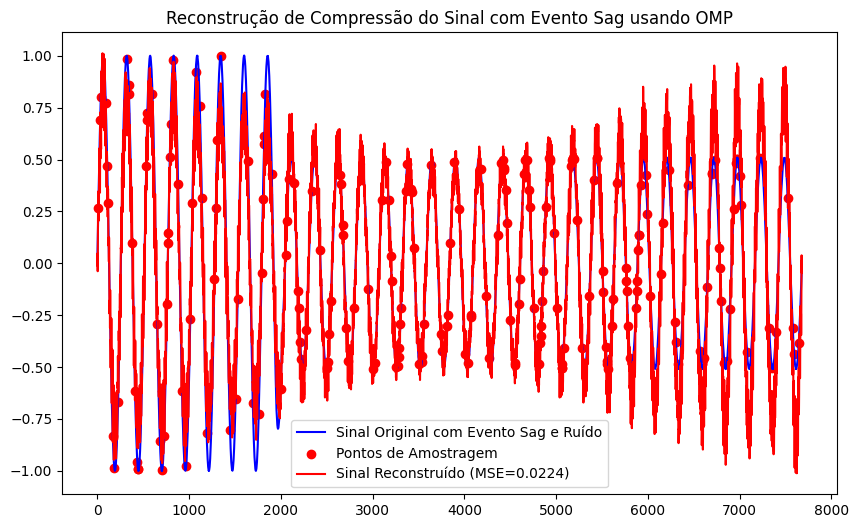

In [4]:

from sklearn.linear_model import OrthogonalMatchingPursuit

def omp(Phi, u, s):
    omp_model = OrthogonalMatchingPursuit(n_nonzero_coefs=s)
    omp_model.fit(Phi, u)
    return omp_model.coef_

def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed)**2)

# Função para gerar o evento "sag"
def evento_sag(SNRdb):

    Vm1 = 1  # Valor máximo do 1º harmônico
    fase = 0
    FreqFund = 60
    Npc = 256  # Número de Pontos por Ciclo
    Nc = 30  # Número de Ciclos
    Npt = Nc * Npc  # Número total de pontos
    Fs = Npc * 60  # Frequência de Amostragem
    T = 1 / Fs  # Período de amostragem
    w0 = 2 * np.pi * FreqFund  # Frequência em Radianos
    t = np.arange(0, T * Npt, T)

    # Parâmetros do evento "sag"
    no = np.random.randint(7 * Npc, 8 * Npc)  # Índice do início do sag
    n = no
    afundamento = np.random.uniform(0.1, 0.9)
    passo = afundamento / (Npc / 4)

    # Geração do ruído
    Ps = (Vm1 ** 2) / 2
    Pr = Ps / (10 ** (SNRdb / 10))
    desvio = np.sqrt(Pr)
    R = np.random.normal(0, desvio, Nc * Npc)
    R -= np.mean(R)

    # Geração do evento "sag"
    x1 = np.zeros(Nc * Npc)
    for n1 in range(Nc * Npc):
        x1[n1] = Vm1 * np.sin(w0 * t[n1] + fase)
        if no < n1 < (no + (Npc / 4) + 1):
            Vm1 -= passo

    xIn = x1 + R

    return xIn, n, Nc, FreqFund




# Configurações
SNRdb = 60

# Geração do sinal com a introdução de ruído e o evento "sag"
xIn, _, _, _ = evento_sag(SNRdb)

# Parâmetros para a amostragem
p = 220
amostras_aleatorias = np.round(len(xIn) * np.random.rand(p)).astype(int)
y = xIn[amostras_aleatorias]

# Aplicação da Transformada Discreta do Cosseno (DCT)
Phi = np.fft.fft(np.eye(len(xIn), len(xIn)))
CPhi = np.imag(Phi[amostras_aleatorias, :])

# Aplicação do algoritmo OMP para minimização de l1
s_reconstruido_omp = omp(CPhi, y, 10)  # Obtendo o vetor esparso com OMP
x_rec_omp = np.imag(np.fft.fft(s_reconstruido_omp))

# Calcular o MSE
mse_omp = calculate_mse(xIn, x_rec_omp)

# Visualização do sinal original com pontos de amostragem aleatória e erro
plt.figure(figsize=(10, 6))
t = np.arange(0, len(xIn))
plt.plot(t, xIn, 'b', label='Sinal Original com Evento Sag e Ruído')
plt.scatter(amostras_aleatorias, xIn[amostras_aleatorias], color='red', label='Pontos de Amostragem')
plt.plot(t, x_rec_omp, 'r', label=f'Sinal Reconstruído (MSE={mse_omp:.4f})')
plt.title('Reconstrução de Compressão do Sinal com Evento Sag usando OMP')
plt.legend()
plt.show()


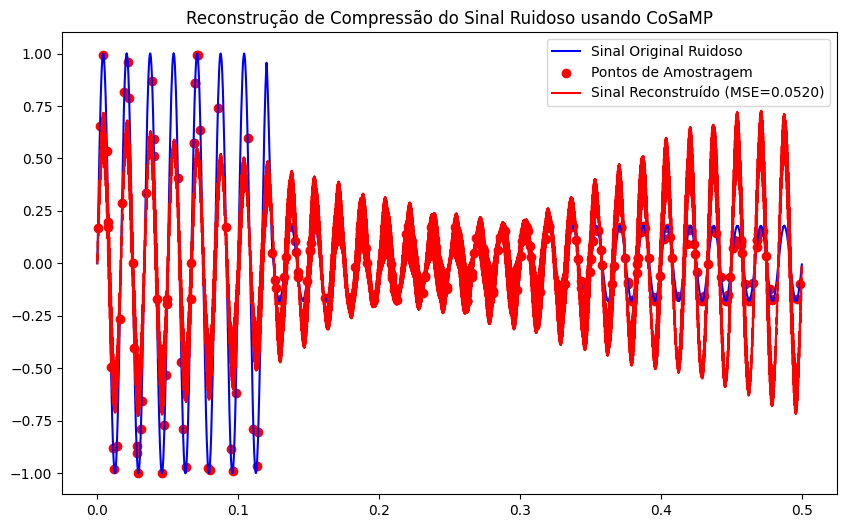

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.linear_model import OrthogonalMatchingPursuit

# Função CoSaMP
def cosamp(Phi, u, s, tol=1e-10, max_iter=10):
    max_iter -= 1
    num_precision = 1e-12
    a = np.zeros(Phi.shape[1])
    v = u
    iter = 0
    halt = False
    while not halt:
        iter += 1
        y = np.abs(np.dot(Phi.T, v))
        Omega = [i for (i, val) in enumerate(y) if val > np.sort(y)[::-1][2 * s] and val > num_precision]
        T = np.union1d(Omega, a.nonzero()[0])
        b = np.dot(np.linalg.pinv(Phi[:, T]), u)
        igood = (np.abs(b) > np.sort(np.abs(b))[::-1][s]) & (np.abs(b) > num_precision)
        T = T[igood]
        a[T] = b[igood]
        v = u - np.dot(Phi[:, T], b[igood])

        halt = np.linalg.norm(v) / np.linalg.norm(u) < tol or iter > max_iter

    return a

# Função para calcular o MSE
def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed)**2)

# Função para o evento sag
def evento_sag(SNRdb, n, T, Npc, Nc, FreqFund):
    Vm1 = 1
    fase = 0
    w0 = 2 * np.pi * FreqFund

    t = T * np.arange(0, n)
    x1 = Vm1 * np.sin(w0 * t + fase)

    afundamento = np.random.uniform(0.1, 0.9)
    passo = afundamento / (Npc / 4)

    no = np.random.randint(7 * Npc, 8 * Npc)
    n = no

    Ps = ((Vm1)**2) / 2
    Pr = Ps / (10**(SNRdb / 10))
    desvio = np.sqrt(Pr)
    R = np.random.normal(0, desvio, len(t))
    R -= np.mean(R)

    for n1 in range(0, len(t)):
        x1[n1] = Vm1 * np.sin(w0 * t[n1] + fase)
        if n1 > no and n1 < (no + (Npc / 4) + 1):
            Vm1 = Vm1 - passo

    xIn = x1 + R

    return xIn, n, Nc, FreqFund

# Configurações
SNRdb = 60
Npc = 256
T = 1 / (Npc * 60)
Nc = 30
n = Nc * Npc
FreqFund = 60

# Geração do sinal com a introdução de ruído (Evento Sag)
xIn, _, _, _ = evento_sag(SNRdb, n, T, Npc, Nc, FreqFund)

# Adiciona o mesmo ruído usado na função evento_sag
noisy_signal = np.zeros(len(xIn))
noisy_signal[:len(xIn)] = xIn

# Amostragem aleatória do sinal ruidoso
p = 220
amostras_aleatorias = np.round((len(xIn)) * np.random.rand(p)).astype(int)
y = noisy_signal[amostras_aleatorias]

# Aqui {y} = [C]{x} = [C][Phi]{s}, onde Phi é a transformada discreta do cosseno inversa
Phi = fft(np.eye(n, n))
CPhi = np.imag(Phi[amostras_aleatorias, :])

# CoSaMP para minimização de l1
s_reconstruido_cosamp = cosamp(CPhi, y, 10)  # obter o vetor esparso através do algoritmo CoSaMP
x_rec_cosamp = np.imag(fft(s_reconstruido_cosamp))

# Calcular o MSE
mse_cosamp = calculate_mse(noisy_signal, x_rec_cosamp)

# Visualizar o sinal original ruidoso com pontos de amostragem aleatória e erro
plt.figure(figsize=(10, 6))
t = T * np.arange(0, len(xIn))
plt.plot(t, xIn, 'b', label='Sinal Original Ruidoso')
plt.scatter(np.arange(0, T * n, T)[amostras_aleatorias], xIn[amostras_aleatorias], color='red', label='Pontos de Amostragem')
plt.plot(t, x_rec_cosamp, 'r', label=f'Sinal Reconstruído (MSE={mse_cosamp:.4f})')
plt.title('Reconstrução de Compressão do Sinal Ruidoso usando CoSaMP')
plt.legend()
plt.show()
